# Project 2
Following is the code for my second data science project at Metis/Chicago. 

**Title**: Predicting Points in Soccer League

**Blog**: click [here](https://tangming2008.github.io/project/)

This project mainly consists of two parts:
* Scape the information from the web
* Apply linear regression model to correlate features with target

## Import packages

In [1]:
from __future__ import print_function, division

import pandas as pd
import numpy as np
import seaborn as sns

import requests
import pickle
import requests

import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

## Scrape the data from internet
Scrape the data from the fox website

Two datasets were used:  
1. [Standings](http://www.foxsports.com/soccer/standings?competition=2&season=2013): total scores
2. [Team stats](http://www.foxsports.com/soccer/team-stats?competition=2&season=20130&category=STANDARD): detailed infor

Write a function which can scrape the data from the table available on the fox website.

In [2]:
def year_to_season (year_start):
    '''
    input: start year of the season
    output: the season string
    '''
    season = f'{year_start}-{year_start + 1}'
    return season

def year_to_url_standings (year_start):
    '''
    get data of "standings" with respect to the year
    '''
    url = f'http://www.foxsports.com/soccer/standings?competition=2&season={year_start}'
    return url

def year_to_url_stats (year_start):
    '''
    get data of "stats" with respect to the year    
    '''
    url = f'http://www.foxsports.com/soccer/team-stats?competition=2&season={year_start}0&category=standard&sort=1'
    return url

def df_standings_change_title (df, year_start):
    '''
    for 'standings' data, change title of features
    '''
    df['Season'] = year_to_season (year_start)
    df.columns = ['Team', 'Played', 'Points', 'Win', 'Draw', 'Lose', 'Goals_Scored', 'Goals_Kicked', 'Goals_diff', 'Home', 'Away', 'Season']
    cols = ['Season', 'Team', 'Played', 'Points', 'Win', 'Draw', 'Lose', 'Goals_Scored', 'Goals_Kicked', 'Goals_diff', 'Home', 'Away']
    df = df.loc[:,cols]
    return df

def df_stats_change_title (df):
    '''
    for 'stats' data, change title of features
    '''
    df.columns = ['Team','Played', 'Goals', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides']
    cols = ['Team','Played', 'Goals', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides']
    df = df.loc[:,cols]
    return df

In [3]:
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

def correct_teamname(teamname):
    '''
    correct and standardize the teamname
    '''    
    correct_teamnames = ['Alaves', 'Athletic Bilbao', 'Atletico Madrid', 'Barcelona', 'Betis', 'Celta Vigo', 'Deportivo La Coruna', 
     'Eibar', 'Espanyol', 'Granada', 'Las Palmas', 'Leganes', 'Malaga', 'Osasuna', 'Real Madrid', 
     'Real Sociedad', 'Sevilla', 'Sporting Gijon', 'Valencia', 'Villarreal']
    
    new_name, score = process.extractOne(teamname, correct_teamnames)
    if score < 30:
        return teamname, score
    else:
        return new_name, score

/Users/MingTang/anaconda/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
def table_list_standings(year_start):
    '''
    input: 'stats' data from website
    output: raw dataframe
    ''' 
    season = year_to_season(year_start)
    url = year_to_url_standings(year_start) 

    # scrap the data from the foxsports website
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')  

    # locate the table which contains the information I need    
    contents = soup.find(class_='wisbb_expandableTable wisbb_teamFixed wisbb_standingsTable')
    
    my_list = []
    
    for table in contents.find_all('td'):
        title = table.text
        title = title.strip()
        title = title.strip('\n')
        title = title.replace('\n','')
        # title = re.split('(\d+)',title)
        title = title.replace(',', '')
        # print(title)
        my_list.append(title)
        # print(my_list)
    
    df = pd.DataFrame(np.array(my_list).reshape(20,11))
    
    df_standings_change_title(df, year_start)
    
    df['Team'], df['Name_score'] = zip(*df['Team'].apply(correct_teamname))
    
    return df

In [5]:
df_2013_standings = table_list_standings(2013)
df_2013_standings.head()

,Team,Played,Points,Win,Draw,Lose,Goals_Scored,Goals_Kicked,Goals_diff,Home,Away,Season,Name_score
0,Atletico Madrid,38,90,28,6,4,77,26,51,15-4-0,13-2-4,2013-2014,85
1,Barcelona,38,87,27,6,5,100,33,67,16-2-1,11-4-4,2013-2014,82
2,Real Madrid,38,87,27,6,5,104,38,66,16-1-2,11-5-3,2013-2014,85
3,Athletic Bilbao,38,70,20,10,8,66,39,27,13-4-2,7-6-6,2013-2014,67
4,Sevilla,38,63,18,9,11,69,52,17,11-4-4,7-5-7,2013-2014,90


In [6]:
def table_list_stats(year_start):
    '''
    input: 'stats' data from website
    output: raw dataframe
    ''' 
    season = year_to_season(year_start)
    url = year_to_url_stats(year_start) 

    # scrap the data from the foxsports website
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')  

    # locate the table which contains the information I need    
    contents = soup.find(class_='wisbb_expandableTable wisbb_teamFixed wisbb_statsTable')
    
    my_list = []
    
    for table in contents.find_all('td'):
        title = table.text
        title = title.strip()
        title = title.strip('\n')
        title = title.replace('\n','')
        # title = re.split('(\d+)',title)
        title = title.replace(',', '')
        # print(title)
        my_list.append(title)
        # print(my_list)
    
    df = pd.DataFrame(np.array(my_list).reshape(20,12))
    
    df_stats_change_title(df)
    
    # df['Team'], df['Name_score'] = zip(*df['Team'].apply(correct_team))
    
    return df

In [7]:
df_2013_stats = table_list_stats(2013).head(5)
df_2013_stats['Team'], df_2013_stats['Name_score'] = zip(*df_2013_stats['Team'].apply(correct_teamname))
df_2013_stats.head()

,Team,Played,Goals,Assist,Shots_On_Goal,Shots,Goals_Header,Goals_Kicked,Cards_Yellow,Cards_Red,Fouls,Offsides,Name_score
0,Real Madrid,38,104,79,315,740,14,89,75,2,451,145,90
1,Barcelona,38,100,72,290,641,5,91,73,1,425,110,90
2,Atletico Madrid,38,77,56,212,486,18,56,97,2,523,130,86
3,Sevilla,38,69,48,180,500,10,58,120,8,569,121,90
4,Athletic Bilbao,38,66,46,203,503,18,46,81,3,484,80,56


# Explore the data

Two example data frames above are representative results scraped from the internet. For simplicity, I combined all results for the past 4 years into a csv file, which is later used for linear regression analysis. The raw data is available from my Github account ([link here](https://raw.githubusercontent.com/tangming2008/Projects/master/02_Soccer/data/laliga3.csv))

In [8]:
df_all = pd.read_csv('https://raw.githubusercontent.com/tangming2008/Projects/master/02_Soccer/data/laliga3.csv') 
# read the csv file, this is the raw data I complied together with results got from the website.

df = df_all
df.columns = ['Season', 'Rank', 'Team', 'Played', 'Win', 'Draw', 'Loss', 'Goal_for', 'Goal_against', 'Goal_diff', 'Points', 'Played', 'Goals', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides']
df['Goal_index'] = df['Goal_for'] / (df['Goal_for'] + df['Goal_against'])
df['match_check'] = df['Goal_for'] - df['Goals'] # this is to check the match between two datasets
cols = ['Season', 'Rank', 'Team', 'Points', 'Goal_for', 'Goal_against', 'Goal_diff', 'Goals', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides', 'Played', 'Win', 'Draw', 'Loss', 'Played']
df = df.loc[:,cols]

df.sort_values(by='Rank',ascending=True).head()

,Season,Rank,Team,Points,Goal_for,Goal_against,Goal_diff,Goals,Assist,Shots_On_Goal,...,Cards_Red,Fouls,Offsides,Played,Played,Win,Draw,Loss,Played,Played
3,2014-2015,1,Barcelona,94,110,21,89,110,80,291,...,3,369,120,38,38,30,4,4,38,38
74,2016-2017,1,Real Madrid,93,106,41,65,106,81,282,...,2,422,136,38,38,29,6,3,38,38
22,2013-2014,1,Atletico Madrid,90,77,26,51,77,56,212,...,2,523,130,38,38,28,6,4,38,38
42,2015-2016,1,Barcelona,91,112,29,83,112,79,277,...,1,385,120,38,38,29,4,5,38,38
23,2013-2014,2,Barcelona,87,100,33,67,100,72,290,...,1,425,110,38,38,27,6,5,38,38


### Split train/test
* Training data: results from 2014 - 2017, named "df", 60 rows
* Test data: results from 2013-2014, names ""df_test", 20 rows

In [9]:
df_test = df[df['Season'] == '2013-2014']
# df_test.describe()

In [10]:
df = df[df['Season'] != '2013-2014']
# df.describe()

### Check the linear correlation between the goals scored & goals lost and the final points

In [11]:
def plot_linear(df, x, y):
    '''
    plot the linear correlation
    '''
    ax = sns.regplot(df[x], df[y])
    plt.xlabel(x, rotation=0, fontsize=label_font_size, weight='bold')
    plt.ylabel(y, rotation=90, fontsize=label_font_size, weight='bold')
    plt.xticks(rotation=axis_rotation, fontsize=axis_font_size)
    plt.yticks(rotation=axis_rotation, fontsize=axis_font_size)
    ax.grid(False)
    
def plot_scatter(df, x, y):
    '''
    make a scatter plot
    '''
    plt.scatter(df[x], df[y]) 
    plt.xlabel(x, rotation=0, fontsize=label_font_size, weight='bold')
    plt.ylabel(y, rotation=90, fontsize=label_font_size, weight='bold')
    plt.xticks(rotation=axis_rotation, fontsize=axis_font_size)
    plt.yticks(rotation=axis_rotation, fontsize=axis_font_size)

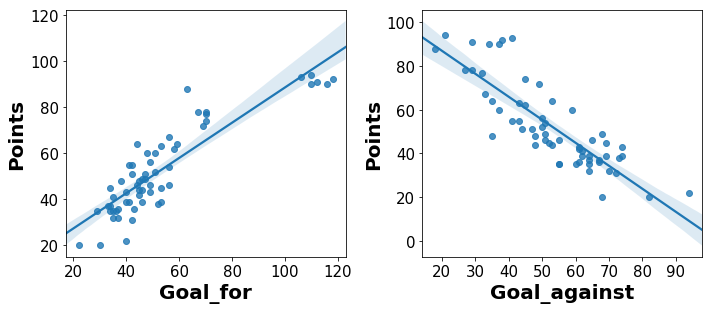

In [12]:
plt.figure(figsize=(10,8))

axis_rotation = 0
axis_font_size = 15
label_rotation = 0
label_font_size = 20

plt.subplot(221);
plot_linear(df, 'Goal_for', 'Points')

plt.subplot(222)
plot_linear(df, 'Goal_against', 'Points')

plt.tight_layout()
# tight_layout automatically adjusts subplot params so that the subplot(s) fits in to the figure area. 

### Correlation between a single feature (*goals scored*) and the target (*final points*)

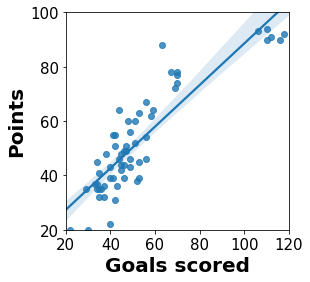

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(4,4)

ax = sns.regplot(df['Goal_for'], df['Points'])
ax.grid(False)

ax.set_xlim([20, 120])
plt.xticks([20, 40, 60, 80, 100, 120])
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([20, 100])
plt.yticks([20, 40, 60, 80, 100])
plt.yticks(rotation=0, fontsize=15)

plt.xlabel('Goals scored', rotation=0, fontsize=label_font_size, weight='bold')
plt.ylabel('Points', rotation=90, fontsize=label_font_size, weight='bold')

# Linear Regression
Steps:
1. Make pairplot & map to visulize the dependence between features and targets
2. Performed linear fitting with statsmodels

In [14]:
# remove other unnecessary columns
cols_all = ['Points', 'Goal_for', 'Goal_against', 'Goal_diff', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides']
df_corr = df.loc[:,cols_all]
df_corr.head()

,Points,Goal_for,Goal_against,Goal_diff,Assist,Shots_On_Goal,Shots,Goals_Header,Goals_Kicked,Cards_Yellow,Cards_Red,Fouls,Offsides
0,32,35,64,-29,22,131,398,6,26,125,11,557,59
1,55,42,41,1,26,153,441,11,30,100,4,526,92
2,78,67,29,38,48,197,443,25,39,117,4,543,100
3,94,110,21,89,80,291,631,16,92,69,3,369,120
4,51,47,44,3,33,177,501,9,36,119,5,581,111


In [15]:
df_corr.corr().sort_values('Points')

,Points,Goal_for,Goal_against,Goal_diff,Assist,Shots_On_Goal,Shots,Goals_Header,Goals_Kicked,Cards_Yellow,Cards_Red,Fouls,Offsides
Goal_against,-0.842390,-0.593030,1.000000,-0.847566,-0.602743,-0.548748,-0.498873,-0.353229,-0.545530,0.526635,0.327417,0.414663,-0.393152
Cards_Yellow,-0.613230,-0.643178,0.526635,-0.664431,-0.651467,-0.626257,-0.599927,-0.297136,-0.630932,1.000000,0.556187,0.732396,-0.314841
Fouls,-0.534670,-0.652456,0.414663,-0.619408,-0.672743,-0.678433,-0.658300,-0.308909,-0.651648,0.732396,0.283492,1.000000,-0.304316
Cards_Red,-0.394784,-0.352766,0.327417,-0.382039,-0.357481,-0.312691,-0.264739,-0.150179,-0.360021,0.556187,1.000000,0.283492,-0.239425
Goals_Header,0.542403,0.596555,-0.353229,0.554507,0.647479,0.550340,0.556111,1.000000,0.452127,-0.297136,-0.150179,-0.308909,0.336044
Offsides,0.602229,0.620706,-0.393152,0.588657,0.610310,0.670468,0.645484,0.336044,0.594795,-0.314841,-0.239425,-0.304316,1.000000
Shots,0.745031,0.877055,-0.498873,0.805899,0.881104,0.943418,1.000000,0.556111,0.846901,-0.599927,-0.264739,-0.658300,0.645484
Shots_On_Goal,0.824391,0.950725,-0.548748,0.877233,0.939472,1.000000,0.943418,0.550340,0.922160,-0.626257,-0.312691,-0.678433,0.670468
Goals_Kicked,0.828934,0.966633,-0.545530,0.886248,0.941965,0.922160,0.846901,0.452127,1.000000,-0.630932,-0.360021,-0.651648,0.594795
Goal_for,0.884015,1.000000,-0.593030,0.929933,0.977698,0.950725,0.877055,0.596555,0.966633,-0.643178,-0.352766,-0.652456,0.620706


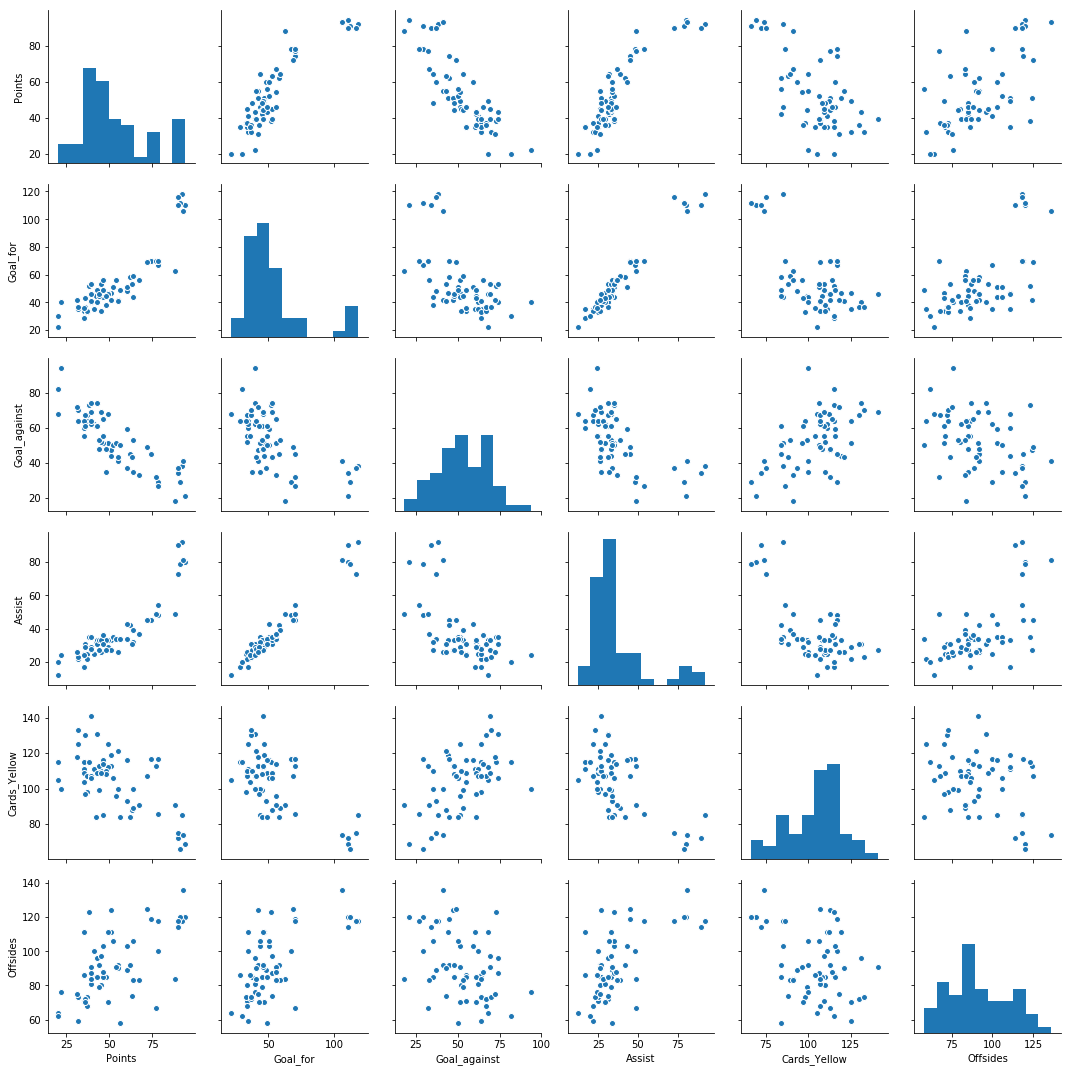

In [16]:
import seaborn as sns
cols_pair = ['Points', 'Goal_for', 'Goal_against', 'Assist', 'Cards_Yellow', 'Offsides']
df_pair = df.loc[:,cols_pair]

sns.pairplot(df_pair)
# sns.pairplot(df_corr)

#### Note that the coeff of -1 indicates a strong negative correlation. A coeff of 0 (light blue) implies weak dependence.

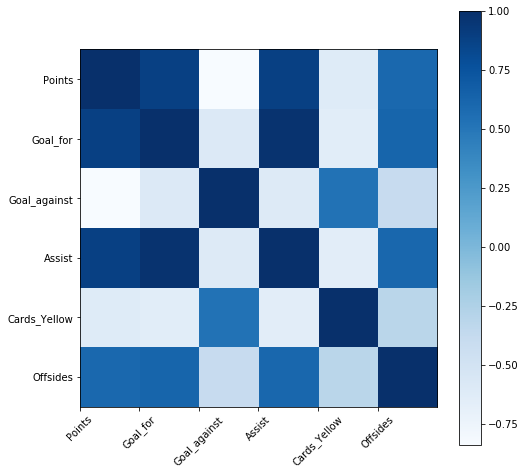

In [17]:
smaller_df = df_pair

corr = smaller_df.corr()
corr.shape

plt.figure(figsize=(8,8))
ax = plt.gca()
plt.imshow(corr, cmap='Blues', interpolation='nearest')
cbar = plt.colorbar()
plt.grid(False)
plt.yticks(np.arange(corr.shape[1]))
plt.xticks(np.arange(corr.shape[0])-0.5, rotation=45)
ax.set_xticklabels(list(smaller_df.columns), minor=False)
ax.set_yticklabels(list(smaller_df.columns), minor=False);

### I started the quantitative analysis with the correlation between a single feature of ""Goal_for" and the target of "Points". The distribution of residuals seems normal, which supports the linear fitting.

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model1 = smf.ols('Points ~ Goal_for', data=df_corr)
fit1 = model1.fit()
# fit1.summary()

/Users/MingTang/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [19]:
print('Parameters: ', fit1.params)
print('R2: ', fit1.rsquared)
print('adjusted_R2: ', fit1.rsquared_adj)

Parameters:  Intercept    12.026718
Goal_for      0.765351
dtype: float64
R2:  0.781481760946
adjusted_R2:  0.7777142051


### Plotting Residuals

(array([-30, -20, -10,   0,  10,  20,  30]),
 <a list of 7 Text yticklabel objects>)

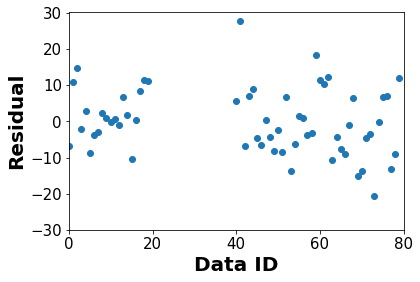

In [20]:
fit1.resid.plot(style='o')
plt.xlabel('Data ID', rotation=0, fontsize=20, weight='bold') # data 21-40 is left for testing, not for training
plt.ylabel('Residual',rotation=90, fontsize=20, weight='bold')

plt.grid(False)
ax.set_xlim([0,80])
plt.xticks([0, 20, 40, 60, 80])
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([-30, 30])
plt.yticks([-30, -20, -10, 0, 10, 20, 30])
plt.yticks(rotation=0, fontsize=15)

In [21]:
model2 = smf.ols('Points ~ Goal_for + Goal_against', data=df_corr)
fit2 = model2.fit()
# fit2.summary()

In [22]:
model3 = smf.ols('Points ~ Goal_for + Goal_against + Goal_diff + Assist + Shots_On_Goal + Shots + Goals_Kicked', data=df_corr)
fit3 = model3.fit()
# fit3.summary()

In [23]:
model4 = smf.ols('Points ~ Goal_for + Goal_against + Goal_diff + Assist + Shots_On_Goal + Shots + Goals_Header + Goals_Kicked + Cards_Yellow + Cards_Red + Fouls + Offsides', data=df_corr)
fit4 = model4.fit()
# fit4.summary()

## Model optimization

I compared R_squ and r_squ_adj to justify the optimization of the model. The final model assumes linear model and includes two features (goals scored and goals lost). The adjusted R score indicates a good linear fit and low complexity avoids overfitting.

(array([ 0.8 ,  0.85,  0.9 ,  0.95,  1.  ]),
 <a list of 5 Text yticklabel objects>)

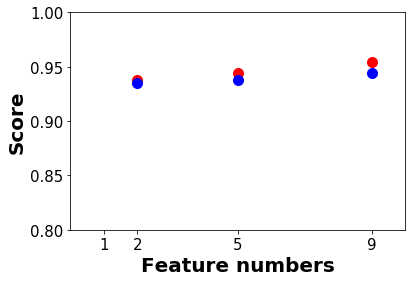

In [24]:
r_group = [1, fit1.rsquared, fit1.rsquared_adj, 2, fit2.rsquared, fit2.rsquared_adj, 5, fit3.rsquared, fit3.rsquared_adj, 9, fit4.rsquared, fit4.rsquared_adj]
df_r = pd.DataFrame(np.array(r_group).reshape(-1,3), columns = ('id', 'sq', 'sq_adj'))
df_r
ax = df_r.plot.scatter(['id'], ['sq'], color='r', s=100)
df_r.plot.scatter(['id'], ['sq_adj'], color='b', ax=ax, s=100)

plt.xlabel('Feature numbers', rotation=0, fontsize=20, weight='bold')
plt.ylabel('Score',rotation=90, fontsize=20, weight='bold')

ax.set_xlim([0,10])
plt.xticks([1, 2, 5,9])
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([0.8,1])
plt.yticks([0.8, 0.85, 0.9, 0.95, 1])
plt.yticks(rotation=0, fontsize=15)

# labels = ['R squared', 'R squared adjusted']
# ax.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

(array([ 0.92,  0.94,  0.96]), <a list of 3 Text yticklabel objects>)

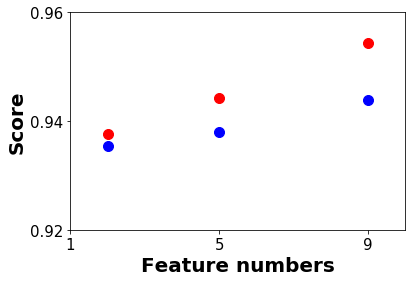

In [25]:
ax = df_r.plot.scatter(['id'], ['sq'], color='r', s=100)
df_r.plot.scatter(['id'], ['sq_adj'], color='b', ax=ax, s=100)

plt.xlabel('Feature numbers', rotation=0, fontsize=20, weight='bold')
plt.ylabel('Score',rotation=90, fontsize=20, weight='bold')

ax.set_xlim([2, 10])
plt.xticks([1, 5, 9])
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([0.92,0.96])
plt.yticks([0.92, 0.94, 0.96])
plt.yticks(rotation=0, fontsize=15)

Final model

In [26]:
# remove other unnecessary columns
cols_final = ['Points', 'Goal_for', 'Goal_against']

df_train = df.loc[:,cols_final] # 80 rows, 3 columns
df_test = df_test.loc[:,cols_final] # 80 rows, 3 columns

model_final = smf.ols('Points ~ Goal_for + Goal_against', data=df_train)
fit_final = model_final.fit()

# df_train.describe()
# df_test.describe()
# fit_final.summary()

coef_1 = 0.5305
coef_2 = -0.5903
inter = 55.6632

# Model prediction / Validation
The model above was validated with test data (2013-2014 season): it correctly estimated final points for most teams but failed to predict the champion of that year.

In [27]:
X = df_test.drop(['Points'], axis = 1) 
y = df_test['Points']
df_test['Predict'] = df_test['Goal_for'] * coef_1 + df_test['Goal_against'] * coef_2 + inter
x= df_test['Points']
y = df_test['Predict']

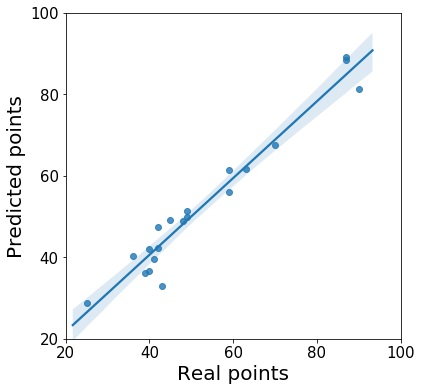

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.regplot(x, y)
# ax.scatter(x,y)

ax.set_xlim([20, 100])
plt.xticks([20, 40, 60, 80, 100]) # 20, 40, 60, 
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([20, 100])
plt.yticks([20, 40, 60, 80, 100]) # 20, 40, 60, 
plt.yticks(rotation=0, fontsize=15)

plt.xlabel('Real points', rotation=0, fontsize=20)#, weight='bold')
plt.ylabel('Predicted points',rotation=90, fontsize=20)#, weight='bold')

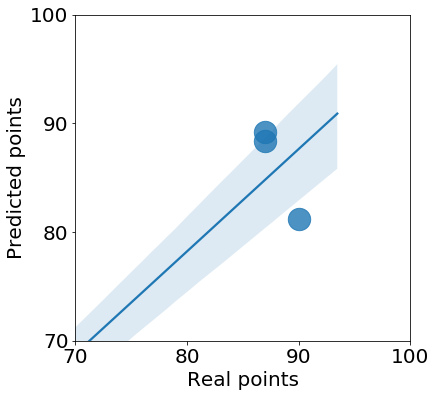

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.regplot(x, y, scatter_kws={"s": 500})
# ax.scatter(x,y)

ax.set_xlim([70, 100])
plt.xticks([70, 80, 90, 100]) # 20, 40, 60, 
plt.xticks(rotation=0, fontsize=20)#, weight='bold')

ax.set_ylim([70, 100])
plt.yticks([70, 80, 90, 100]) # 20, 40, 60, 
plt.yticks(rotation=0, fontsize=20)#, weight='bold')
plt.xlabel('Real points', rotation=0, fontsize=20) #weight='')
plt.ylabel('Predicted points',rotation=90, fontsize=20)#, weight='bold')

In [30]:
df_2013 = df_all[df_all['Season'] == '2013-2014']
df_2013_top2 = df_2013[df_2013['Rank'] < 4]
df_2013_top2['Predict'] = df_2013_top2['Goal_for'] * coef_1 + df_2013_top2['Goal_against'] * coef_2 + inter
cols_final = ['Team', 'Rank', 'Points', 'Predict', 'Goal_for', 'Goal_against', 'Goal_diff', 'Assist', 'Shots_On_Goal', 'Shots', 'Goals_Header', 'Goals_Kicked', 'Cards_Yellow', 'Cards_Red', 'Fouls', 'Offsides']
df_2013_top2 = df_2013_top2.loc[:,cols_final] # 80 rows, 3 columns
df_2013_top2.head()

/Users/MingTang/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Team,Rank,Points,Predict,Goal_for,Goal_against,Goal_diff,Assist,Shots_On_Goal,Shots,Goals_Header,Goals_Kicked,Cards_Yellow,Cards_Red,Fouls,Offsides
22,Atletico Madrid,1,90,81.1639,77,26,51,56,212,486,18,56,97,2,523,130
23,Barcelona,2,87,89.2333,100,33,67,72,290,641,5,91,73,1,425,110
34,Real Madrid,3,87,88.4038,104,38,66,79,315,740,14,89,75,2,451,145


In [31]:
df_2013_final3 = pd.read_csv('https://raw.githubusercontent.com/tangming2008/Projects/master/02_Soccer/data/2013.csv') # read the csv file
# pd.to_numeric(df_2013_final3)
df_2013_final3.columns = ['Game', 'AM_goal_for', 'AM_goal_against','Barca_goal_for',  'Barca_goal_against','RM_goal_for', 'RM_goal_against']
df_2013_final3['AM'] = df_2013_final3['AM_goal_for'] - df_2013_final3['AM_goal_against']
df_2013_final3['Barca'] = df_2013_final3['Barca_goal_for'] - df_2013_final3['Barca_goal_against']
df_2013_final3['RM'] = df_2013_final3['RM_goal_for'] - df_2013_final3['RM_goal_against']
cols_2013_final3 = ['Game', 'AM_goal_for', 'AM_goal_against','Barca_goal_for',  'Barca_goal_against','RM_goal_for', 'RM_goal_against', 'AM', 'Barca', 'RM']
df_2013_final3 = df_2013_final3.loc[:,cols_2013_final3] # 80 rows, 3 columns
df_2013_final3 = df_2013_final3.apply(pd.to_numeric)

The following graph compares the distribution of goals difference among top 3 teams and can be used to explain why the model fails at the extreme values. The details of the distribution of features during **each match** matters. 'AM' (Atlético Madrid) scored less, but this team lost much less goals (the 2nd bottom line is higher than other two teams). 3 points means the best after one match: 1:0 is more efficient than a victory.

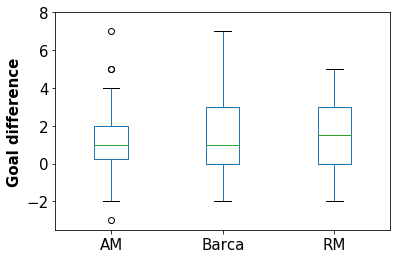

In [32]:
cols_plot = ['AM', 'Barca', 'RM']
df_plot = df_2013_final3.loc[:,cols_plot]
df_plot.plot.box()

# ax.set_xlim([20, 100])
# plt.xticks([20, 40, 60, 80, 100])
plt.xticks(rotation=0, fontsize=15)

ax.set_ylim([-3, 8])
plt.yticks([-2, 0, 2 , 4, 6, 8])
plt.yticks(rotation=0, fontsize=15)

plt.ylabel('Goal difference',rotation=90, fontsize=15, weight='bold')